In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import tensorflow as tf

import ND_north_star.src.noise_generators.perlin_noise_generator as PNG
import ND_north_star.src.edge_detection.complex as ED_com
import ND_north_star.src.edge_detection.gradient_detection as ED_sim

## Generate dataset

In [3]:
resolution = 30
octaves = 4
dataset_size = 1000

In [4]:
dataset = [PNG.ND_perlin_matrix([resolution, resolution], octaves=octaves, noise_cutoff_list=[0.5, 0, 1]) for _ in range(dataset_size)]

In [5]:
from sklearn.preprocessing import MinMaxScaler

def perlin_M_to_dict(dimension_resolution, octaves, perlin_matrix):
    
    # Convert list to numpy array if needed
    array = np.array(perlin_matrix)
    shape = array.shape
 
    # Generate all possible coordinates in the N-dimensional array
    coordinates = np.indices(shape).reshape(len(shape), -1).T
    data = []      
    # Iterate over the coordinates and get the corresponding values
    for coord in coordinates:
        value = array[tuple(coord)]
        data.append(list(coord) + [value])
    
    # Separate the features and the value column
    features = [d[:-1] for d in data]
    values = [d[-1] for d in data]
    
    # Normalize the feature columns
    scaler = MinMaxScaler()
    normalized_features = scaler.fit_transform(features)
    
    # Create the output dictionary
    perlin_dict = {
        'features': normalized_features.tolist(),
        'values': values,
        'resolution': dimension_resolution,
        'coordinates': [f'x{i}' for i in range(len(shape))],
        'octaves': octaves,
        'dimension': len(dimension_resolution),
    }
    
    return perlin_dict

In [6]:
dict_dataset = [perlin_M_to_dict([resolution, resolution], octaves, m) for m in dataset]

In [7]:
def perlin_M_to_coords(perlin_matrix):
    # Initialize empty lists for coordinates and values
    coordinates = []
    values = []

    # Helper function to recursively flatten the nested data
    def recursive_flatten(current_data, current_coords):
        for i, item in enumerate(current_data):
            if isinstance(item, list):
                # If the item is a list, recursively flatten it
                recursive_flatten(item, current_coords + [i])
            else:
                # If the item is a value, store its coordinates and value
                coordinates.append(current_coords + [i])
                values.append(item)

    # Start the recursive flattening process
    recursive_flatten(perlin_matrix, [])

    # Determine the number of dimensions
    num_dimensions = max(map(len, coordinates))

    # Create separate arrays for each dimension
    coordinate_arrays = [np.array([coord[dim] if dim < len(coord) else 0 for coord in coordinates]) for dim in range(num_dimensions)]

    # Convert the values list to a NumPy array
    values_array = np.array(values)

    return coordinate_arrays, values_array


In [8]:
def drop_coords(input_coord_array, values, drop_perc=0.5):
    num_points = len(input_coord_array[0])
    num_points_to_drop = int(num_points * drop_perc)
    
    drop_indices = np.random.choice(num_points, num_points_to_drop, replace=False)

    keep_coord_array = [np.delete(coord, drop_indices, axis=0) for coord in input_coord_array]
    keep_values = np.delete(values, drop_indices, axis=0)

    return keep_coord_array, keep_values

In [9]:
X = np.zeros([dataset_size, resolution, resolution])
for i in range(dataset_size):
    coord_array, values = perlin_M_to_coords(dataset[i])
    dropped_coords_array_50, dropped_values_50 = drop_coords(coord_array, values, 0.5)
    dropped_img = np.zeros([resolution, resolution])
    for j in range(len(dropped_values_50)):
        x = dropped_coords_array_50[0][j]
        y = dropped_coords_array_50[1][j]
        dropped_img[x][y] = dropped_values_50[j]
        X[i] = dropped_img 

In [10]:
y = [ED_sim.gradient_edge_detection(dataset[i]) for i in range(dataset_size)]

In [11]:
# X_sparse = [tf.sparse.from_dense(image) for image in X]
# y_sparse = [tf.sparse.from_dense(image) for image in y]

## Train test split

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, range(len(X)), random_state=2345)

## CNN

In [14]:
from tensorflow import keras
from keras import models
from keras import layers

In [15]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(resolution,resolution,1,), padding = 'same'),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Conv2DTranspose(1, (3,3), activation='sigmoid')
])

/Users/yangxiaoluo/miniconda3/envs/nd-path-finder/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

In [17]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['mse'])

In [18]:
X_train_tensor = tf.convert_to_tensor(X_train)
y_train_tensor = tf.convert_to_tensor(y_train)
X_test_tensor = tf.convert_to_tensor(X_test)
y_test_tensor = tf.convert_to_tensor(y_test)

In [19]:
epochs=1000
history = model.fit(X_train_tensor, y_train_tensor, validation_data=(X_test_tensor, y_test_tensor),
                      epochs=epochs, 
                      batch_size=512)

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - loss: 24.4683 - mse: 0.2489 - val_loss: 24.3928 - val_mse: 0.2493
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 24.4050 - mse: 0.2492 - val_loss: 24.3440 - val_mse: 0.2483
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 24.3614 - mse: 0.2481 - val_loss: 24.2952 - val_mse: 0.2465
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 24.3076 - mse: 0.2462 - val_loss: 24.2421 - val_mse: 0.2431
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 24.2438 - mse: 0.2425 - val_loss: 24.1810 - val_mse: 0.2376
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 24.2022 - mse: 0.2367 - val_loss: 24.1108 - val_mse: 0.2302
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 24.1331 - mse: 0.2291 - val_loss: 24.0295 - val_mse: 0.2212
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 24.0502 - mse: 0.2200 - val_loss: 23.9362 - val_mse: 0.2115
Epoch 9/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s

In [20]:
model.save("../../checkpoints/"+str(epochs)+".keras")

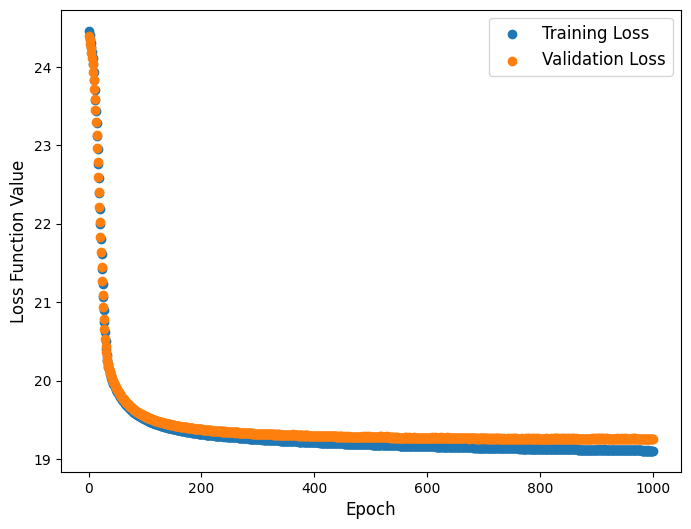

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8,6))
plt.scatter(range(1, epochs + 1),history.history['loss'], label = "Training Loss")
plt.scatter(range(1, epochs + 1),history.history['val_loss'], label = "Validation Loss")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss Function Value", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=12)

plt.show()

In [22]:
pred = model.predict(X_test_tensor)
pred_01 = [e>0.5 for e in pred]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [26]:
n = 25
nn = indices_test[n]

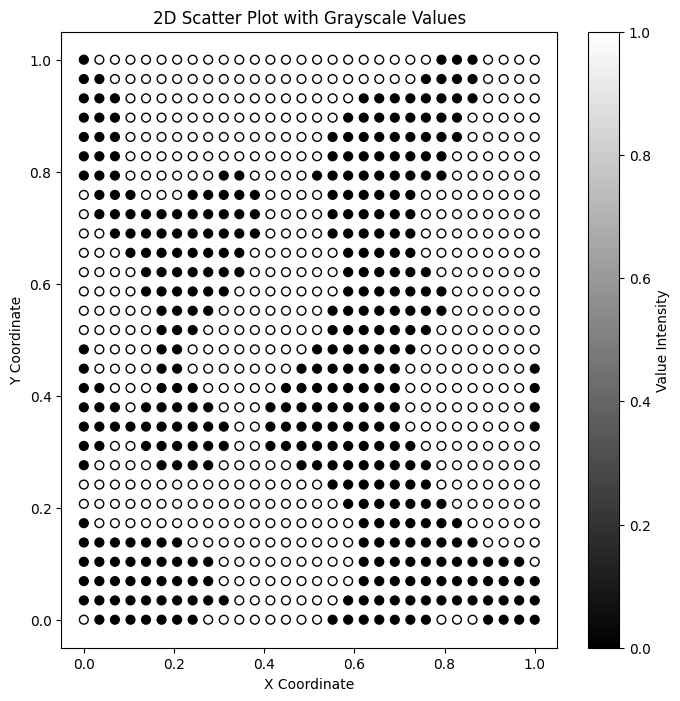

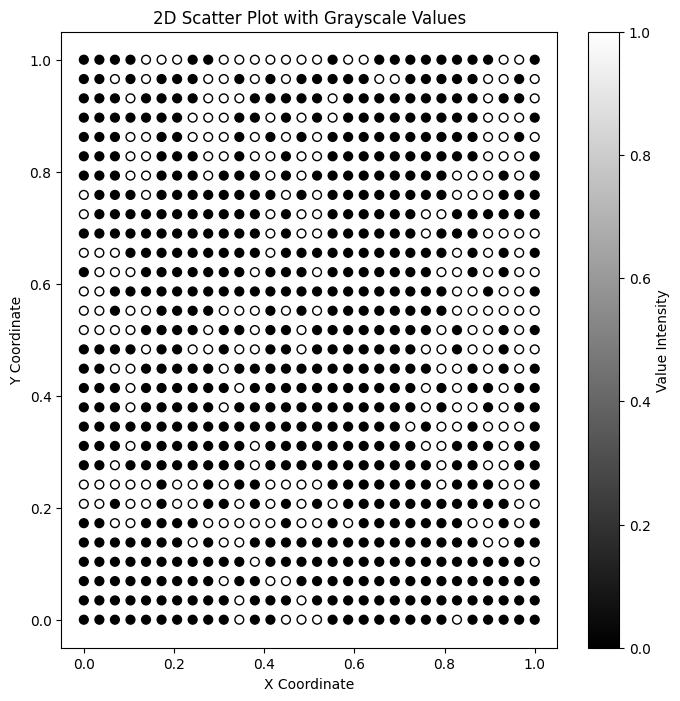

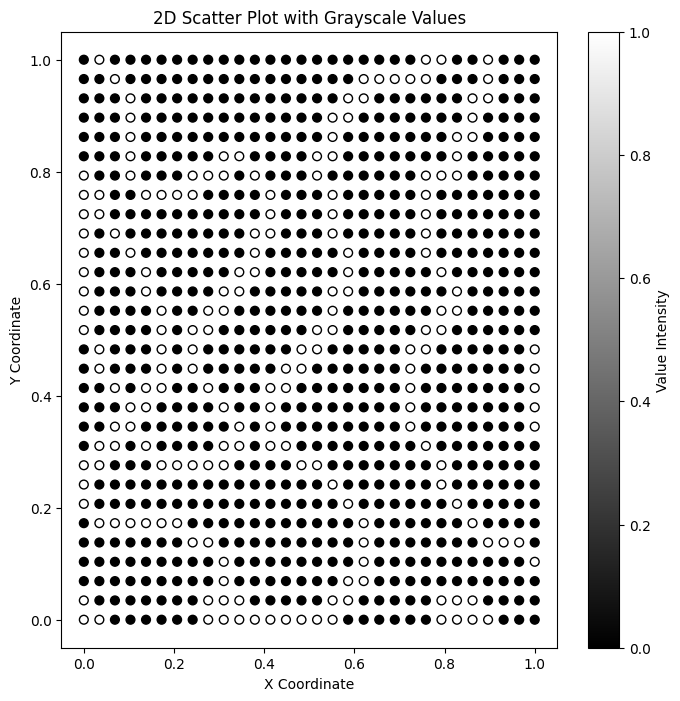

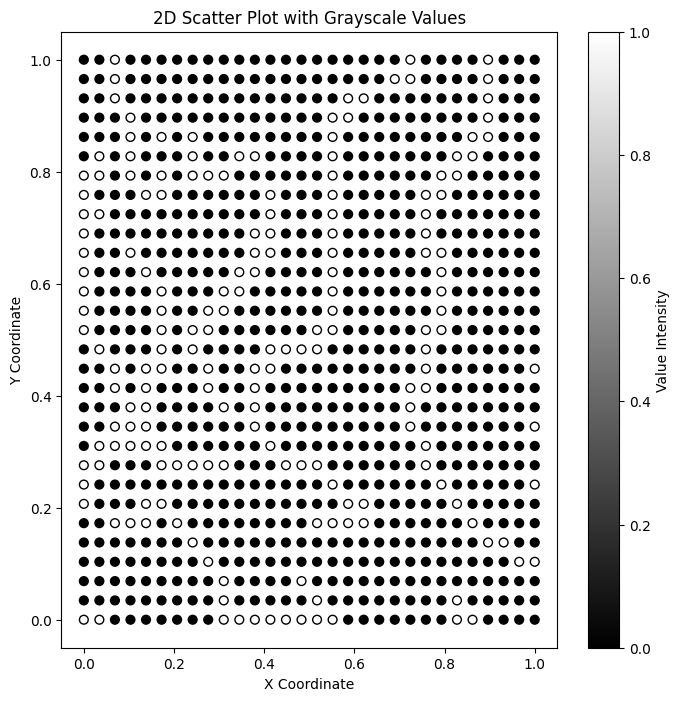

In [27]:
PNG.plot_perlin_2D_3D(perlin_M_to_dict([resolution, resolution], 2, dataset[nn]), 'black')
PNG.plot_perlin_2D_3D(perlin_M_to_dict([resolution, resolution], 2, X_test[n]), 'black')
PNG.plot_perlin_2D_3D(perlin_M_to_dict([resolution, resolution], 2, y_test[n]), 'black')
# PNG.plot_perlin_2D_3D(perlin_M_to_dict([resolution, resolution], 2, pred[n]), 'black')
PNG.plot_perlin_2D_3D(perlin_M_to_dict([resolution, resolution], 2, pred_01[n]), 'black')

In [25]:
from sklearn.metrics import mean_squared_error

np.mean([mean_squared_error(np.array(y_test).astype(float)[i], np.array(pred>0.5).reshape(np.array(y_test).shape)[i]) for i in range(len(y_test))])

0.12089333333333334